<a href="https://colab.research.google.com/github/KJ-black/Machine-Learning-on-Material-Informatics/blob/main/projectile_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Collection

## Data Generation

In [240]:
import numpy as np
import random
import pandas as pd

n = 100000 # number of dataset
data = []
title = ['angle', 'velocity', 'height', 'distance']
for i in range(n):
  angle = random.uniform(0, np.pi/2)
  v = random.uniform(0, 100)
  h = ((v*np.sin(angle))**2)/(2*9.8)
  d = (v**2*2*np.sin(angle)*np.cos(angle))/9.8
  data.append([angle, v, h, d])
data = np.array(data)
pd_data = pd.DataFrame(data, columns=title)
print(data.shape)

(100000, 4)


## Original Data Visiualization

### Input Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea29ea7250>,
      dtype=object)

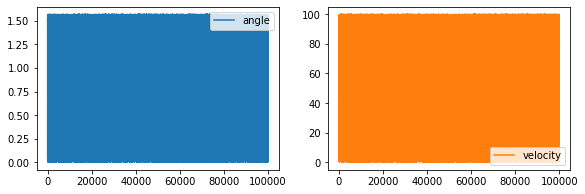

In [241]:
pd_data[['angle', 'velocity']].plot(subplots=True, layout=(1, 4), figsize=(20, 3))

Output Data (Target Data)

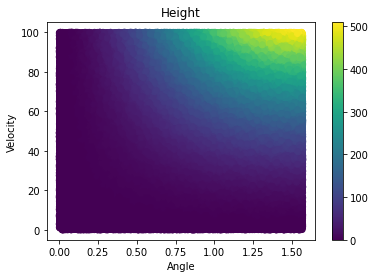

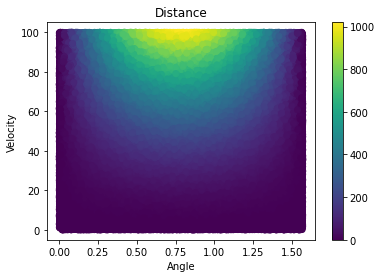

In [242]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Height")
plt.xlabel("Angle")
plt.ylabel("Velocity")
plt.scatter(data[:,0], data[:, 1], c=data[:,2], cmap="viridis")
plt.colorbar()
plt.show()

plt.figure()
plt.title("Distance")
plt.xlabel("Angle")
plt.ylabel("Velocity")
plt.scatter(data[:,0], data[:, 1], c=data[:,3], cmap="viridis")
plt.colorbar()
plt.show()

## Train Test Split

In [243]:
split_num = int(n*0.8)
x = data[:split_num, :2]
y = data[:split_num, 2:]
x_test = data[split_num:, :2]
y_test = data[split_num:, 2:]
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x.shape: (80000, 2)
y.shape: (80000, 2)
x_test.shape: (20000, 2)
y_test.shape: (20000, 2)


# 2. Feature Engineering

## Normalization

In [244]:
from sklearn.preprocessing import MinMaxScaler

# Training Set
x_sc = MinMaxScaler()
y_sc = MinMaxScaler()
x = x_sc.fit_transform(x)
y = y_sc.fit_transform(y)

# Testing Set
x_test = x_sc.transform(x_test)

### Normalized Data Visiualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea2a5efd10>,
      dtype=object)

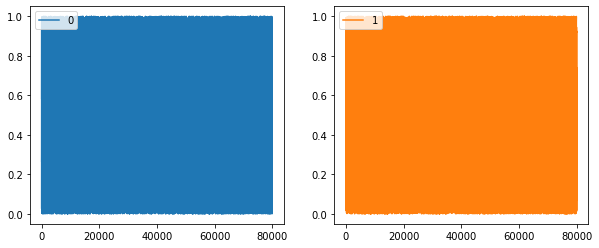

In [245]:
pd_x_train = pd.DataFrame(x)
pd_x_train.plot(subplots=True, layout=(1, 2), figsize=(10, 4))

# 3. ANN

## Model Architecture

In [246]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ANNModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(ANNModel, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(input_dim, 16),
      nn.ReLU(),
      nn.Linear(16, 64),
      nn.ReLU(),
      nn.Linear(64, 16), 
      nn.ReLU(), 
      nn.Linear(16, output_dim)
    )

  def forward(self, x):

    return self.layers(x)

## DataLoader

In [247]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=8888)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
x_val = torch.from_numpy(x_val).float().to(device)
y_val = torch.from_numpy(y_val).type(torch.float).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train, y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

Using device: cpu


## Initialze Weight

In [248]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0, 0.02)
    nn.init.constant_(m.bias.data, 0)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

input_dim = x_train.shape[1] # feature size
output_dim = y_train.shape[1]
model = ANNModel(input_dim, output_dim).to(device)
weights_init(model)

## Training & Validation

In [249]:
loss_list = []
val_list = []
loss_fn = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
epoch = 200

for iteration in range(epoch):
  avg_loss, avg_acc = 0, 0
  for j, (inputs, targets) in enumerate(train_loader):
    
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record
    avg_loss += loss.item()
    n_correct = torch.sum((torch.abs(outputs - targets) < torch.abs(0.1* targets)))
    avg_acc = (n_correct.item() * 100.0 / (len(targets)*2))  # scalar
 
  avg_loss /= len(train_loader)
  loss_list.append(avg_loss)
  


  ## val 
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in test_loader:
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct = torch.sum((torch.abs(pred - y) < torch.abs(0.1* y)))
  correct = (correct.item() * 100.0 / (len(x)*2) ) # scalar  test_loss /= len(test_loader)
  val_list.append(test_loss)

  # if iteration%10 == 0 :
  #   print("=======================================================")
  #   print('Train\tEpoch:%2d\tLoss:%.4f'%(iteration, avg_loss))
  #   print('Val\tEpoch:%2d\tLoss:%.4f'%(iteration, test_loss))
  #   print("=======================================================")


  if iteration%10 == 0 :
    print("=======================================================")
    print('Train\tEpoch:%2d\tLoss:%.4f\t\tAcc:%.4f'%(iteration+10, avg_loss, avg_acc))
    print('Val\tEpoch:%2d\tLoss:%.4f\t\tAcc:%.4f'%(iteration+10, test_loss, correct))
    print("=======================================================")

Train	Epoch:10	Loss:0.0156		Acc:29.2614
Val	Epoch:10	Loss:0.0280		Acc:33.4821
Train	Epoch:20	Loss:0.0000		Acc:70.2415
Val	Epoch:20	Loss:0.0011		Acc:63.9509
Train	Epoch:30	Loss:0.0000		Acc:70.1705
Val	Epoch:30	Loss:0.0015		Acc:68.1920
Train	Epoch:40	Loss:0.0000		Acc:69.5312
Val	Epoch:40	Loss:0.0010		Acc:73.4375
Train	Epoch:50	Loss:0.0000		Acc:76.5625
Val	Epoch:50	Loss:0.0004		Acc:75.7812
Train	Epoch:60	Loss:0.0000		Acc:71.0227
Val	Epoch:60	Loss:0.0004		Acc:70.4241
Train	Epoch:70	Loss:0.0000		Acc:79.9716
Val	Epoch:70	Loss:0.0002		Acc:76.8973
Train	Epoch:80	Loss:0.0000		Acc:77.6989
Val	Epoch:80	Loss:0.0002		Acc:76.0045
Train	Epoch:90	Loss:0.0000		Acc:75.7102
Val	Epoch:90	Loss:0.0001		Acc:77.4554
Train	Epoch:100	Loss:0.0000		Acc:71.3778
Val	Epoch:100	Loss:0.0006		Acc:72.0982
Train	Epoch:110	Loss:0.0000		Acc:75.4261
Val	Epoch:110	Loss:0.0002		Acc:79.4643
Train	Epoch:120	Loss:0.0000		Acc:79.5455
Val	Epoch:120	Loss:0.0003		Acc:74.8884
Train	Epoch:130	Loss:0.0000		Acc:79.6875
Val	Epoch:130	Los

## Results

### Plot loss

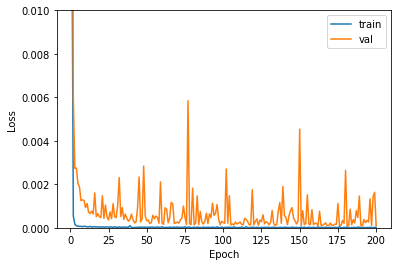

In [253]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 0.01)
x = np.arange(1, len(loss_list)+1)
plt.plot(x, loss_list, label="train")
plt.plot(x, val_list, label='val')
plt.legend()
plt.show()

### Test

In [251]:
x_test = torch.from_numpy(x_test).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)
with torch.no_grad():
  pred = model(x_test)
  pred = y_sc.inverse_transform(pred)
  pred = torch.from_numpy(pred).type(torch.float).to(device)
  h_loss = loss_fn(pred[:, 0], y_test[:, 0]).item()
  d_loss = loss_fn(pred[:, 1], y_test[:, 1]).item()
print("H loss:", h_loss)
print("D loss:", d_loss)

acc_list = []
for j in range(2):
  acc = 0.0
  for i in range(len(y_test[:, j])):
    if np.abs(pred[i, j]-y_test[i,j]) < y_test[i,j]*0.1:
      acc += 1
  acc /= len(y_test[:, j])
  acc_list.append(acc*100)

print(acc_list)
x_test = x_test.numpy()
y_test = y_test.numpy()

H loss: 1.137341856956482
D loss: 4.243843078613281
[76.48, 82.69]


### Correlation of Ground Truth and Prediction

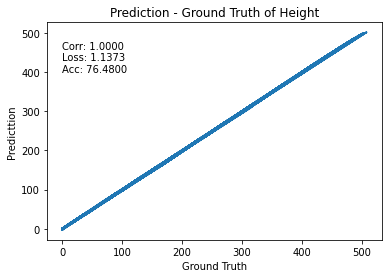

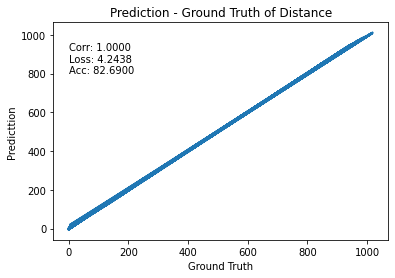

In [252]:
from scipy.stats import pearsonr

plt.title( "Prediction - Ground Truth of Height")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_test[:, 0], pred[:, 0] )# plot( x, y)
corr, _ = pearsonr(y_test[:, 0], pred[:, 0])
slope = "Corr: " + "%.4f"%corr + "\nLoss: " + "%.4f"%h_loss +"\nAcc: " + "%.4f"%acc_list[0]
plt.text( 0, 400, slope)
plt.show()

plt.title( "Prediction - Ground Truth of Distance")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_test[:, 1], pred[:, 1] )# plot( x, y)
corr, _ = pearsonr(y_test[:, 1], pred[:, 1])
slope = "Corr: " + "%.4f"%corr + "\nLoss: " + "%.4f"%d_loss +"\nAcc: " + "%.4f"%acc_list[1]
plt.text( 0, 800, slope)
plt.show()